In [28]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import numpy as np
import sys
import os
import pydot
import graphviz

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath('../../'))

import utils.ml_util
importlib.reload(utils.ml_util)
from utils.ml_util import *

import utils.trading_util
importlib.reload(utils.trading_util)
from utils.trading_util import *

[*********************100%***********************]  1 of 1 completed


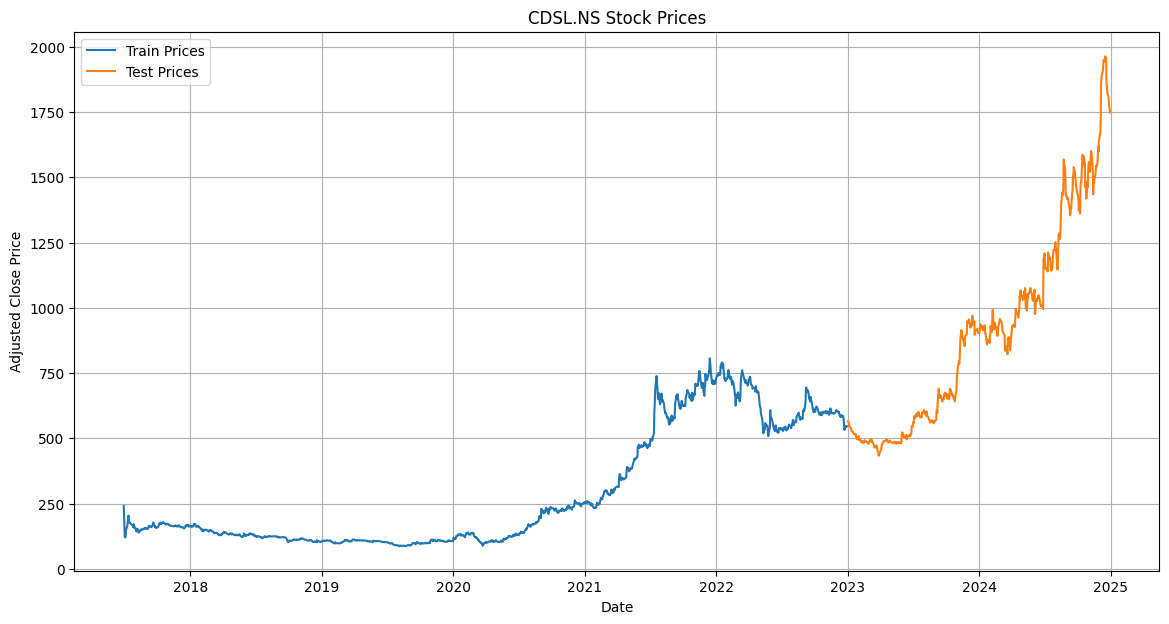

In [29]:
TKR = 'CDSL.NS'
MAX_HOLDING = 100
MAX_HISTORY = 200
FEATURE_KERNEL_SIZES = [5, 10]
TEST_TRAIN_SPLIT = pd.Timestamp('2023-01-01')
TIME_EFFECT = 2

historic_prices = yf.download(TKR)['Adj Close']
train_prices, test_prices = historic_prices[TKR][:TEST_TRAIN_SPLIT].to_list(), historic_prices[TKR][TEST_TRAIN_SPLIT:].to_list()
plt.figure(figsize=(14, 7))
plt.plot(historic_prices[TKR][:TEST_TRAIN_SPLIT], label='Train Prices')
plt.plot(historic_prices[TKR][TEST_TRAIN_SPLIT:], label='Test Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title(f'{TKR} Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
outlook = []
for pos1 in range(len(train_prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (train_prices[pos1 + pos2] - train_prices[pos1]) * time_effect[TIME_EFFECT](MAX_HOLDING, pos2)
    outlook.append(ans / time_effect_integrals[TIME_EFFECT](MAX_HOLDING))
    
n_outlook = normalize_average(outlook, MAX_HOLDING * 3)

In [31]:
features = get_sma_sd_v(train_prices, FEATURE_KERNEL_SIZES, MAX_HISTORY)[:-MAX_HOLDING - 1]
n_outlook = n_outlook[MAX_HISTORY + max(FEATURE_KERNEL_SIZES) - 1:]

x = np.array(features)
y = np.array(n_outlook)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def create_model():
    inputs = tf.keras.layers.Input(shape=(len(x_train[0]),))
    
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    residual_1 = x
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, residual_1])
    
    residual_2 = x
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, residual_2])
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    outputs = tf.keras.layers.Dense(1, activation='tanh')(x)
    
    return tf.keras.models.Model(inputs, outputs)

model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='mean_absolute_error')
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1200)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │    307,456 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_24[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 512)       │    131,584 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_25[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 256)       │    131,328 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_26[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 512)       │    131,584 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_27[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │    131,328 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_28[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 128)       │     32,896 │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_29[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128)       │          0 │ batch_normalizat

 Total params: 882,433 (3.37 MB)

 Trainable params: 878,465 (3.35 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


In [33]:
model.fit(x=x_train, 
        y=y_train, 
        epochs=50, 
        validation_data=(x_test, y_test), 
    )

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.7167 - val_loss: 1.2213
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5872 - val_loss: 0.9411
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5783 - val_loss: 0.6794
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5474 - val_loss: 0.7166
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5234 - val_loss: 0.7112
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4941 - val_loss: 0.5685
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4710 - val_loss: 0.5876
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4555 - val_loss: 0.3984
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4254 - val_loss: 0.4132
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4440 - val_loss: 0.3869
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3988 - val_loss: 0.3490
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4

In [34]:
features = get_sma_sd_v(test_prices, FEATURE_KERNEL_SIZES, MAX_HISTORY)
test_prices = test_prices[MAX_HISTORY + max(FEATURE_KERNEL_SIZES) - 1:]

x = np.array(features)

p_outlook = model.predict(x)
p_outlook = [x[0] for x in p_outlook]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [35]:
account = Account()
stock = Stock(TKR, test_prices[0])
MAX_TRANSACTION = 1

buy_positions = []
sell_positions = []
executed_sell_orders = []
executed_cover_orders = []

net_worth = []
min_balance = 0

for pos in range(len(test_prices)):
    stock.update_price(test_prices[pos])
    
    if p_outlook[pos] > 0.2:
        account.buy(stock, abs(MAX_TRANSACTION * p_outlook[pos]))
        buy_positions.append((pos, test_prices[pos]))
    elif p_outlook[pos] < -0.2:
        account.sell(stock, abs(MAX_TRANSACTION * p_outlook[pos]))
        sell_positions.append((pos, test_prices[pos]))
    
    net_worth.append(float(account.net_worth()))
    if account.balance < min_balance:
        min_balance = account.balance
        
sharpe_ratio = calculate_sharpe_ratio(net_worth, account.min_balance)

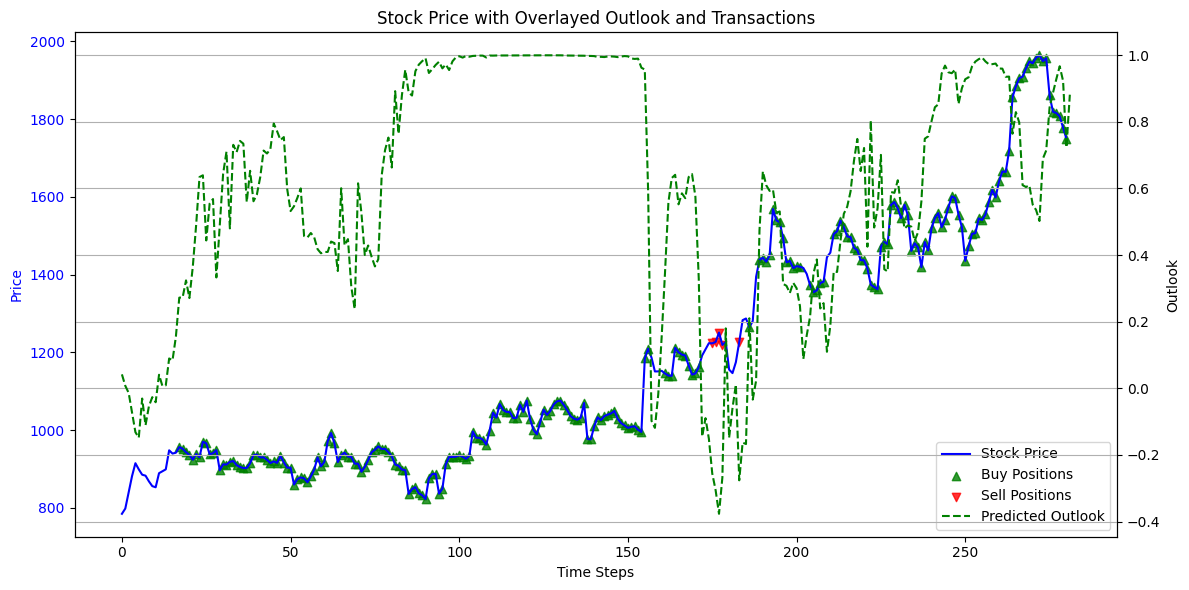

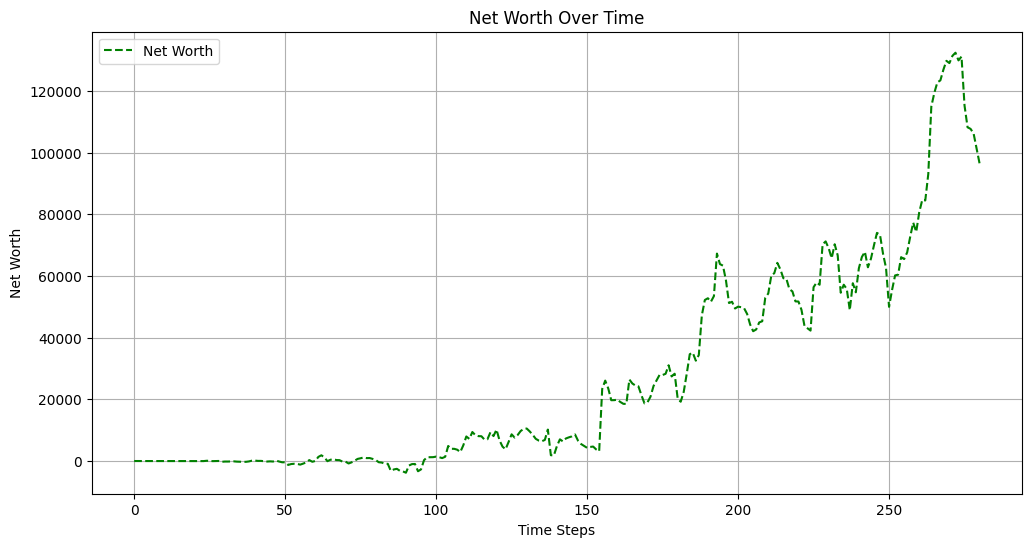

Balance: $-203254.33
Net Worth: $96385.98
Total Profit: 47.42%
Holdings:
CDSL.NS: 171.32583618164062 shares
Stock Profit: 122.94%
Sharpe Ratio: 1.62


In [36]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(range(len(test_prices)), test_prices, label="Stock Price", color="blue")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

buy_x, buy_y = zip(*buy_positions) if buy_positions else ([], [])
ax1.scatter(buy_x, buy_y, label="Buy Positions", color="green", marker="^", alpha=0.8)

sell_x, sell_y = zip(*sell_positions) if sell_positions else ([], [])
ax1.scatter(sell_x, sell_y, label="Sell Positions", color="red", marker="v", alpha=0.8)

ax2 = ax1.twinx()
ax2.plot(range(len(p_outlook)), p_outlook, label="Predicted Outlook", color="green", linestyle="--")
ax2.set_ylabel("Outlook", color="black")
ax2.tick_params(axis="y", labelcolor="black")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower right")

plt.title("Stock Price with Overlayed Outlook and Transactions")
plt.grid()
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(len(net_worth)), net_worth, label="Net Worth", color="green", linestyle="--")

plt.title("Net Worth Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Net Worth")
plt.legend()
plt.grid()

plt.show()

print(account)
print(f"Stock Profit: {(test_prices[-1] - test_prices[0]) / test_prices[0] * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")